In [6]:
import math
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import numpy as np
import os
import torch
import sentence_transformers
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import torch.nn as nn

from transformers import BertTokenizer, BertModel, pipeline, BartModel
from transformers import RobertaTokenizer, RobertaModel, AutoConfig
from transformers import AutoTokenizer, AutoModel

from sentence_transformers.util import cos_sim
from sentence_transformers import SentenceTransformer, models
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F
from DeBERTa import deberta
from collections import OrderedDict

import textstat

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [8]:
model_name = 'base'
size = 768

In [9]:
def config_debert():
    configuration = deberta.ModelConfig()
    configuration = configuration.from_json_file(r"C:\Users\shmak\.~DeBERTa\assets\latest\deberta-base\model_config.json")

    configuration.attention_probs_dropout_prob = 0.0
    configuration.hidden_dropout_prob = 0.0

    return configuration

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = RobertaTokenizer.from_pretrained()

In [11]:
# DeBERTa model
#
# vocab_path, vocab_type = deberta.load_vocab(pretrained_id='large')
# tokenizer = deberta.tokenizers[vocab_type](vocab_path)

embeddings_model = deberta.DeBERTa(config=config_debert(), pre_trained=model_name)

08/17/2023 22:34:23|INFO|logging|00| Loaded pretrained model file C:\Users\shmak\.~DeBERTa/assets/latest/deberta-base\pytorch_model.bin


## Data

In [12]:
summaries_train_path = r"dataset\summaries_train_merged.csv"
summaries_test_path = r"dataset\summaries_test.csv"
prompts_train_path = r"dataset\prompts_train.csv"
prompts_test_path = r"dataset\prompts_test.csv"

In [13]:
def norm_score(df: pd.DataFrame) -> pd.DataFrame:
    """Normilizing score to values 0 to 1"""
    df -= np.min(df)
    df /= df.max()
    print('Normilized' if df.min() == 0.0 and df.max() == 1.0 else 'NormError:wrong values')

    return df

def short_text(text, max_length=200) -> str:
    if len(text.split()) > 700:
        middle_point = text[len(text)//2:].index('.') + len(text)//2 + 1
        text_pt1 = text[:middle_point]
        text_pt2 = text[middle_point:]

        text = short_text(text_pt1) + short_text(text_pt2)

    summarizer = pipeline("summarization", model="bart-large-cnn")

    # summarizer.model.to(device)

    summarized = summarizer(text, max_length=max_length, min_length=80, do_sample=False)

    return summarized[0]['summary_text']

def moving_average(array: np.array, betta=0.9) -> np.array:
    """
    Computing moving average with bias correction.
    """

    V = 0
    average_array = np.zeros(len(array))
    for i in range(len(array)):
        V = betta * V + (1 - betta) * array[i]
        average_array[i] = V/(1 - pow(betta, i+1))

    return average_array


def mean_pooling(outputs, batch) -> torch.tensor:

    attention_mask = batch['attention_mask']
    embeddings = outputs['hidden_states'][-1]

    mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    masked_embeddings = embeddings * mask

    summed = torch.sum(masked_embeddings, 1)
    summed_mask = torch.clamp(mask.sum(dim=1), min=1e-9)

    mean_pooled = summed/summed_mask

    return mean_pooled

def normilize(df_column: pd.DataFrame):

    df_column = (df_column - df_column.mean())/df_column.std()

    return df_column

def get_cos_sim(df):
    sentence_1 = df.text
    sentence_2 = df.prompt_text

    sentence_tokenizer = AutoTokenizer.from_pretrained('all-mpnet-base-v2')
    sentence_model = AutoModel.from_pretrained('all-mpnet-base-v2')

    cos_sim_list = []
    sentence_model.to(device)

    for i, summarie in enumerate(tqdm(sentence_1)):
        prompt = sentence_2[i]
        inputs = sentence_tokenizer([summarie, prompt], padding=True,
                                    return_tensors='pt', truncation=True)
        inputs.to(device)

        with torch.no_grad():
            outputs = sentence_model(**inputs)

        sentence_embeddings = mean_pooling(outputs, inputs)
        sentence_embeddings = F.normalize(sentence_embeddings)

        score = nn.CosineSimilarity(dim=0)(sentence_embeddings[0], sentence_embeddings[1])

        cos_sim_list.append(score.item())

    return cos_sim_list

def get_stat_features(df, text_col="text"):

    df["num_unique_words"] = normilize(df[text_col].apply(lambda x: len(set(x.split()))))
    df["num_words"] = normilize(df[text_col].apply(lambda x: len(x.split())))
    df["num_sentences"] = normilize(df[text_col].apply(lambda x: len(x.split('.'))))

    df["syntax_count"] = normilize(df[text_col].apply(lambda x: x.count(",")
                                                      + x.count("-") + x.count(";") + x.count(":")))
    df['smog_index'] = normilize(df[text_col].apply(lambda x: textstat.smog_index(x)))
    # df['cos_sim'] = normilize(pd.DataFrame(get_cos_sim(df)))

    return df

In [14]:
class SentenseData(Dataset):
    """
    :params: path to csv file with summaries, path to csv file with prompts, 'score' param\
    defines which score is used: content/wording
    """
    def __init__(self, summaries_path=summaries_train_path,
                 prompts_path=prompts_train_path,
                 score='wording', test=False, fold_test='ebad26'):
        self.test = test
        self.score_type = score
        self.fold_test = fold_test

        with open(prompts_path, encoding='utf-8') as f:
            self.prompts = pd.read_csv(f)

        with open(summaries_path, encoding='utf-8') as f:
            summaries = pd.read_csv(f)
            self.summaries = summaries

    def __len__(self):
        return len(self.__summaries)

    @property
    def summaries(self):
        return self.__summaries

    @summaries.setter
    def summaries(self, df):
        if self.test:
            self.__summaries = df[df.prompt_id == self.fold_test].reset_index(drop=True)

        else:
            self.__summaries = df[df.prompt_id != self.fold_test].reset_index(drop=True)

    @property
    def prompts(self):
        return self.__prompts

    @prompts.setter
    def prompts(self, file):
        self.__prompts = file
        # for i, text in enumerate(self.__prompts.prompt_text):
        #     if len(text.split()) > 300:
        #         self.__prompts.prompt_text[i] = short_text(text)

    def get_batch_text(self, index):
        summary_text = self.summaries.text[index]

        if True:#self.score_type == 'wording':
            res = tokenizer(summary_text, padding='max_length', return_tensors='pt', truncation=True)
            res = {k:val.squeeze() for k, val in res.items()}
            res['features'] = torch.tensor([self.summaries['num_unique_words'][index], self.summaries['num_words'][index],
                                  self.summaries['num_sentences'][index],self.summaries['syntax_count'][index],
                                  self.summaries['smog_index'][index]], dtype=torch.float32)

            return res

        prompt_text = self.prompts.prompt_text[self.prompts.prompt_id ==
                                               self.summaries.prompt_id[index]].item().replace('\n','')

        return tokenizer([summary_text, prompt_text], padding='max_length', return_tensors='pt', truncation=True)

    def get_score(self, index):
        if self.score_type == 'content':
            score = self.summaries.content[index]

        elif self.score_type == 'wording':
            score = self.summaries.wording[index]

        return torch.tensor(score)

    def __getitem__(self, index) -> torch.tensor:

        batch_text = self.get_batch_text(index)
        batch_score = self.get_score(index)

        return batch_text, batch_score

## Model

In [15]:
class STSBertModel(nn.Module):
    """
    Sentence Semantic Similarity Bert model
    :param: seg_head=True for using segmentation head instead of cosine similarity
    :param: freeze_weights=True to freeze BERT model's weights and train only the segmentation head
    """
    def __init__(self, with_features=False, input_size=size):
        super(STSBertModel, self).__init__()

        self.word_embedding = deberta.DeBERTa(config=config_debert(), pre_trained=model_name)
        self.cos_score = nn.CosineSimilarity(dim=0)
        self.identity = nn.Identity()
        self.input_size = input_size
        self.with_features = with_features

        if with_features:
            self.n_features = 6
            self.input_size += self.n_features

        # for param in self.word_embedding.parameters():
        #     param.requires_grad = False

        self.attention = SelfAttention(self.input_size)
        self.block = AttentionBlock(self.input_size)

        self.FC_head = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(self.input_size, self.input_size)),
            ('relu1', nn.ReLU()),
            # ('fc2', nn.Linear(1024, self.input_size)),
            # ('relu2', nn.ReLU())
            ]))

        self.FC_output = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(self.input_size, 1)),
            ]))

    def forward(self, x):
        output = self.word_embedding(input_ids=x['input_ids'], attention_mask=x['attention_mask'])
        output = mean_pooling(output, x)

        if self.with_features:
            output = torch.cat((output, x['features']), dim=1)

        output = output.unsqueeze(1)
        output = self.attention(output)
        output = self.FC_output(output)

        return output.squeeze()


class AttentionBlock(nn.Module):
    def __init__(self, input_dim):
        super(AttentionBlock, self).__init__()

        self.input_dim = input_dim
        self.fc = nn.Linear(input_dim, input_dim)
        self.attention = SelfAttention(input_dim)
        self.relu = nn.ReLU()
        self.norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        identity = x

        x = self.attention(x)
        x = self.fc(x)

        x += identity
        x = self.norm(x)
        x = self.relu(x)

        return x


class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted


## Training

In [16]:
def validate_model(model, loss_func):

    losses_epoch_test = []

    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            targets = targets.float().to(device)
            if True:
                inputs = {k:val.squeeze().to(device) for k, val in inputs.items()}

                with torch.autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(inputs)

            else:
                outputs = torch.stack([model(sentence.to(device)) for sentence in inputs])


            loss = torch.sqrt(loss_func(outputs.squeeze(), targets))


            losses_epoch_test.append(loss.item())

    return losses_epoch_test

def train_model(n_epochs, lr, weight_decay, n_fold, lr_head):

    model = STSBertModel(with_features=True)
    # model = ClassificationModel(n_features=7, n_fold=n_fold)

    model.float()
    model.to(device)


    params = [
        {'params': model.word_embedding.parameters()},
        {'params': model.attention.parameters(), 'lr': lr_head},
        {'params': model.block.parameters(), 'lr': lr_head},
        {'params': model.FC_head.parameters(), 'lr': lr_head},
        {'params': model.FC_output.parameters(), 'lr': lr_head}
    ]

    loss_func = nn.MSELoss()
    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

    scaler = torch.cuda.amp.GradScaler()

    losses_train = []
    losses_test = []
    t0 = datetime.now()

    for i in range(n_epochs):

        losses_train_per_epoch = []

        for j, batch in enumerate(tqdm(train_loader, position=0, leave=True), 1):
            inputs, targets = batch
            targets = targets.float().to(device)

            model.train()

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                inputs = {k:val.squeeze().to(device) for k, val in inputs.items()}
                outputs = model(inputs)

                loss = torch.sqrt(loss_func(outputs.squeeze(), targets))

            scaler.scale(loss).backward()
            scaler.step(optimizer)

            scaler.update()

            losses_train_per_epoch.append(loss.item())

            lr_scheduler.step()

            if j%20 == 0 or j == len(train_loader):

                losses_test_per_epoch = validate_model(model, loss_func)
                losses_test_mean = np.mean(losses_test_per_epoch)
                losses_train_mean = np.mean(losses_train_per_epoch)

                losses_train.append(losses_train_mean)
                losses_test.append(losses_test_mean)

                if losses_test_mean == np.min(losses_test):
                    best_score = losses_test_mean
                    n_iter = len(losses_train)
                    torch.save(model.state_dict(), r'models\cv\best__fold_{}.pt'.format(n_fold))
                    print(f'Best saved, loss: {best_score:.5f}')

                print(f'Fold# {n_fold}, Epoch: {i+1}/{n_epochs}, L_train: {losses_train_mean:.5f},\
                L_test: {losses_test_mean:.5f}')

        # lr_scheduler.step()
        torch.cuda.empty_cache()

    print(f"Time elapsed:{datetime.now()-t0}, Best score:{best_score:.5f}")

    return best_score, n_iter, losses_test, losses_train

In [17]:
def loaders_init(score_type, batch_size, fold):

    test_data = SentenseData(test=True, score=score_type, fold_test=fold)
    train_data = SentenseData(score=score_type, fold_test=fold)

    train_loader = DataLoader(train_data,
                           batch_size=batch_size,
                           shuffle=True, drop_last=True)

    test_loader = DataLoader(test_data,
                          batch_size=batch_size,
                          shuffle=True, drop_last=True)

    return train_loader, test_loader

def axis_set(ax):

    ax.plot(test_losses, label='test')
    ax.plot(train_losses, label='train')
    ax.scatter(n_iter - 1, best_score, label='min')
    ax.set_title(f'#{i}, min: {best_score:.5f}', loc='left')
    ax.xaxis.set_major_locator(ticker.LinearLocator(n_epochs + 1))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(n_epochs)))
    ax.legend()

    return ax

08/17/2023 22:34:24|INFO|logging|00| Loaded pretrained model file C:\Users\shmak\.~DeBERTa/assets/latest/deberta-base\pytorch_model.bin
  4%|▍         | 20/510 [00:29<48:31,  5.94s/it]

Best saved, loss: 0.78753
Fold# 1, Epoch: 1/3, L_train: 0.97267,                L_test: 0.78753


  8%|▊         | 40/510 [00:57<46:47,  5.97s/it]

Best saved, loss: 0.68268
Fold# 1, Epoch: 1/3, L_train: 0.87857,                L_test: 0.68268


 12%|█▏        | 60/510 [01:25<44:31,  5.94s/it]

Best saved, loss: 0.65338
Fold# 1, Epoch: 1/3, L_train: 0.84056,                L_test: 0.65338


 16%|█▌        | 80/510 [01:52<41:36,  5.81s/it]

Fold# 1, Epoch: 1/3, L_train: 0.80005,                L_test: 0.67943


 20%|█▉        | 100/510 [02:21<41:20,  6.05s/it]

Best saved, loss: 0.56126
Fold# 1, Epoch: 1/3, L_train: 0.76561,                L_test: 0.56126


 24%|██▎       | 120/510 [02:49<38:25,  5.91s/it]

Fold# 1, Epoch: 1/3, L_train: 0.73158,                L_test: 0.64170


 27%|██▋       | 140/510 [03:18<37:32,  6.09s/it]

Best saved, loss: 0.55355
Fold# 1, Epoch: 1/3, L_train: 0.71128,                L_test: 0.55355


 31%|███▏      | 160/510 [03:46<34:54,  5.98s/it]

Best saved, loss: 0.50668
Fold# 1, Epoch: 1/3, L_train: 0.69044,                L_test: 0.50668


 35%|███▌      | 180/510 [04:14<31:47,  5.78s/it]

Fold# 1, Epoch: 1/3, L_train: 0.67565,                L_test: 0.60695


 39%|███▉      | 200/510 [04:41<29:52,  5.78s/it]

Fold# 1, Epoch: 1/3, L_train: 0.66260,                L_test: 0.64788


 43%|████▎     | 220/510 [05:09<28:42,  5.94s/it]

Best saved, loss: 0.50476
Fold# 1, Epoch: 1/3, L_train: 0.65464,                L_test: 0.50476


 47%|████▋     | 240/510 [05:37<26:00,  5.78s/it]

Fold# 1, Epoch: 1/3, L_train: 0.64201,                L_test: 0.59803


 51%|█████     | 260/510 [06:04<24:02,  5.77s/it]

Fold# 1, Epoch: 1/3, L_train: 0.63131,                L_test: 0.53691


 55%|█████▍    | 280/510 [06:32<22:23,  5.84s/it]

Fold# 1, Epoch: 1/3, L_train: 0.62693,                L_test: 0.51403


 59%|█████▉    | 300/510 [07:01<21:06,  6.03s/it]

Best saved, loss: 0.50374
Fold# 1, Epoch: 1/3, L_train: 0.62111,                L_test: 0.50374


 63%|██████▎   | 320/510 [07:29<18:30,  5.84s/it]

Fold# 1, Epoch: 1/3, L_train: 0.61755,                L_test: 0.55402


 67%|██████▋   | 340/510 [07:56<16:29,  5.82s/it]

Fold# 1, Epoch: 1/3, L_train: 0.61102,                L_test: 0.54218


 71%|███████   | 360/510 [08:24<14:28,  5.79s/it]

Fold# 1, Epoch: 1/3, L_train: 0.60560,                L_test: 0.69952


 75%|███████▍  | 380/510 [08:52<12:48,  5.91s/it]

Fold# 1, Epoch: 1/3, L_train: 0.60351,                L_test: 0.62006


 78%|███████▊  | 400/510 [09:20<11:02,  6.02s/it]

Fold# 1, Epoch: 1/3, L_train: 0.59766,                L_test: 0.57388


 82%|████████▏ | 420/510 [09:49<09:06,  6.07s/it]

Fold# 1, Epoch: 1/3, L_train: 0.59364,                L_test: 0.63164


 86%|████████▋ | 440/510 [10:18<07:23,  6.34s/it]

Best saved, loss: 0.50082
Fold# 1, Epoch: 1/3, L_train: 0.58981,                L_test: 0.50082


 90%|█████████ | 460/510 [10:49<05:56,  7.14s/it]

Fold# 1, Epoch: 1/3, L_train: 0.58473,                L_test: 0.53339


 94%|█████████▍| 480/510 [11:16<02:51,  5.71s/it]

Fold# 1, Epoch: 1/3, L_train: 0.58335,                L_test: 0.52715


 98%|█████████▊| 500/510 [11:42<00:56,  5.70s/it]

Fold# 1, Epoch: 1/3, L_train: 0.58089,                L_test: 0.60255


100%|██████████| 510/510 [12:04<00:00,  1.42s/it]


Fold# 1, Epoch: 1/3, L_train: 0.57975,                L_test: 0.60711


  4%|▍         | 20/510 [00:24<46:26,  5.69s/it]

Best saved, loss: 0.49733
Fold# 1, Epoch: 2/3, L_train: 0.51921,                L_test: 0.49733


  8%|▊         | 40/510 [00:48<44:45,  5.71s/it]

Best saved, loss: 0.48206
Fold# 1, Epoch: 2/3, L_train: 0.49908,                L_test: 0.48206


 12%|█▏        | 60/510 [01:12<42:23,  5.65s/it]

Fold# 1, Epoch: 2/3, L_train: 0.48931,                L_test: 0.57407


 16%|█▌        | 80/510 [01:36<39:59,  5.58s/it]

Fold# 1, Epoch: 2/3, L_train: 0.48065,                L_test: 0.50720


 20%|█▉        | 100/510 [01:59<38:19,  5.61s/it]

Fold# 1, Epoch: 2/3, L_train: 0.48999,                L_test: 0.55823


 24%|██▎       | 120/510 [02:23<36:20,  5.59s/it]

Fold# 1, Epoch: 2/3, L_train: 0.47937,                L_test: 0.60356


 27%|██▋       | 140/510 [02:47<34:38,  5.62s/it]

Fold# 1, Epoch: 2/3, L_train: 0.48758,                L_test: 0.54146


 31%|███▏      | 160/510 [03:11<32:32,  5.58s/it]

Fold# 1, Epoch: 2/3, L_train: 0.48885,                L_test: 0.48527


 35%|███▌      | 180/510 [03:34<30:48,  5.60s/it]

Fold# 1, Epoch: 2/3, L_train: 0.49112,                L_test: 0.63576


 39%|███▉      | 200/510 [03:58<28:33,  5.53s/it]

Fold# 1, Epoch: 2/3, L_train: 0.49649,                L_test: 0.57998


 43%|████▎     | 220/510 [04:21<26:41,  5.52s/it]

Fold# 1, Epoch: 2/3, L_train: 0.49764,                L_test: 0.51745


 47%|████▋     | 240/510 [04:45<25:31,  5.67s/it]

Fold# 1, Epoch: 2/3, L_train: 0.49296,                L_test: 0.50331


 51%|█████     | 260/510 [05:09<23:13,  5.58s/it]

Fold# 1, Epoch: 2/3, L_train: 0.49902,                L_test: 0.55168


 55%|█████▍    | 280/510 [05:33<21:24,  5.58s/it]

Fold# 1, Epoch: 2/3, L_train: 0.50383,                L_test: 0.55945


 59%|█████▉    | 300/510 [05:57<19:27,  5.56s/it]

Fold# 1, Epoch: 2/3, L_train: 0.50524,                L_test: 0.55554


 63%|██████▎   | 320/510 [06:20<17:48,  5.63s/it]

Fold# 1, Epoch: 2/3, L_train: 0.50763,                L_test: 0.74236


 67%|██████▋   | 340/510 [06:45<16:35,  5.86s/it]

Fold# 1, Epoch: 2/3, L_train: 0.51204,                L_test: 0.52950


 71%|███████   | 360/510 [07:09<14:31,  5.81s/it]

Fold# 1, Epoch: 2/3, L_train: 0.51230,                L_test: 0.49671


 75%|███████▍  | 380/510 [07:34<12:47,  5.91s/it]

Fold# 1, Epoch: 2/3, L_train: 0.51325,                L_test: 0.50217


 78%|███████▊  | 400/510 [07:59<10:49,  5.90s/it]

Fold# 1, Epoch: 2/3, L_train: 0.51078,                L_test: 0.56377


 82%|████████▏ | 420/510 [08:23<08:51,  5.91s/it]

Fold# 1, Epoch: 2/3, L_train: 0.50944,                L_test: 0.53391


 86%|████████▋ | 440/510 [08:48<06:52,  5.90s/it]

Fold# 1, Epoch: 2/3, L_train: 0.50796,                L_test: 0.64908


 90%|█████████ | 460/510 [09:13<05:02,  6.06s/it]

Best saved, loss: 0.47846
Fold# 1, Epoch: 2/3, L_train: 0.50635,                L_test: 0.47846


 94%|█████████▍| 480/510 [09:37<02:52,  5.77s/it]

Fold# 1, Epoch: 2/3, L_train: 0.50399,                L_test: 0.54538


 98%|█████████▊| 500/510 [10:00<00:56,  5.60s/it]

Fold# 1, Epoch: 2/3, L_train: 0.50277,                L_test: 0.49266


100%|██████████| 510/510 [10:21<00:00,  1.22s/it]


Fold# 1, Epoch: 2/3, L_train: 0.50326,                L_test: 0.55865


  4%|▍         | 20/510 [00:23<45:50,  5.61s/it]

Fold# 1, Epoch: 3/3, L_train: 0.54576,                L_test: 0.49552


  8%|▊         | 40/510 [00:46<43:54,  5.60s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50131,                L_test: 0.58970


 12%|█▏        | 60/510 [01:10<42:07,  5.62s/it]

Fold# 1, Epoch: 3/3, L_train: 0.48136,                L_test: 0.60031


 16%|█▌        | 80/510 [01:33<39:50,  5.56s/it]

Fold# 1, Epoch: 3/3, L_train: 0.49049,                L_test: 0.60040


 20%|█▉        | 100/510 [01:57<38:38,  5.66s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50178,                L_test: 0.54936


 24%|██▎       | 120/510 [02:20<36:35,  5.63s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50250,                L_test: 0.63534


 27%|██▋       | 140/510 [02:44<34:46,  5.64s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50510,                L_test: 0.71652


 31%|███▏      | 160/510 [03:09<34:37,  5.93s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50222,                L_test: 0.74218


 35%|███▌      | 180/510 [03:33<32:34,  5.92s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50436,                L_test: 0.50136


 39%|███▉      | 200/510 [03:58<30:33,  5.91s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50111,                L_test: 0.60650


 43%|████▎     | 220/510 [04:22<27:53,  5.77s/it]

Fold# 1, Epoch: 3/3, L_train: 0.49835,                L_test: 0.62872


 47%|████▋     | 240/510 [04:45<25:16,  5.62s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50180,                L_test: 0.69593


 51%|█████     | 260/510 [05:09<23:28,  5.63s/it]

Fold# 1, Epoch: 3/3, L_train: 0.49859,                L_test: 0.68264


 55%|█████▍    | 280/510 [05:34<22:37,  5.90s/it]

Fold# 1, Epoch: 3/3, L_train: 0.49512,                L_test: 0.50319


 59%|█████▉    | 300/510 [05:58<20:40,  5.91s/it]

Fold# 1, Epoch: 3/3, L_train: 0.49447,                L_test: 0.52273


 63%|██████▎   | 320/510 [06:23<18:37,  5.88s/it]

Fold# 1, Epoch: 3/3, L_train: 0.48950,                L_test: 0.51696


 67%|██████▋   | 340/510 [06:48<17:15,  6.09s/it]

Fold# 1, Epoch: 3/3, L_train: 0.48732,                L_test: 0.64893


 71%|███████   | 360/510 [07:12<14:31,  5.81s/it]

Fold# 1, Epoch: 3/3, L_train: 0.48423,                L_test: 0.50445


 75%|███████▍  | 380/510 [07:35<12:01,  5.55s/it]

Fold# 1, Epoch: 3/3, L_train: 0.48431,                L_test: 0.49492


 78%|███████▊  | 400/510 [07:59<10:22,  5.66s/it]

Fold# 1, Epoch: 3/3, L_train: 0.48368,                L_test: 0.58007


 82%|████████▏ | 420/510 [08:23<08:41,  5.79s/it]

Fold# 1, Epoch: 3/3, L_train: 0.48730,                L_test: 0.49975


 86%|████████▋ | 440/510 [08:48<07:07,  6.10s/it]

Fold# 1, Epoch: 3/3, L_train: 0.48763,                L_test: 0.71845


 90%|█████████ | 460/510 [09:13<05:04,  6.08s/it]

Fold# 1, Epoch: 3/3, L_train: 0.48849,                L_test: 0.58478


 94%|█████████▍| 480/510 [09:36<02:45,  5.52s/it]

Fold# 1, Epoch: 3/3, L_train: 0.49263,                L_test: 0.56924


 98%|█████████▊| 500/510 [10:00<00:56,  5.63s/it]

Fold# 1, Epoch: 3/3, L_train: 0.49298,                L_test: 0.64500


100%|██████████| 510/510 [10:22<00:00,  1.22s/it]

Fold# 1, Epoch: 3/3, L_train: 0.49117,                L_test: 0.58725
Time elapsed:0:32:48.317441, Best score:0.47846



C:\Users\shmak\AppData\Local\Temp\ipykernel_26924\1272925579.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(n_epochs)))
08/17/2023 23:07:14|INFO|logging|00| Loaded pretrained model file C:\Users\shmak\.~DeBERTa/assets/latest/deberta-base\pytorch_model.bin
  4%|▎         | 19/515 [00:19<08:20,  1.01s/it]


KeyboardInterrupt: 

<Figure size 1200x400 with 0 Axes>

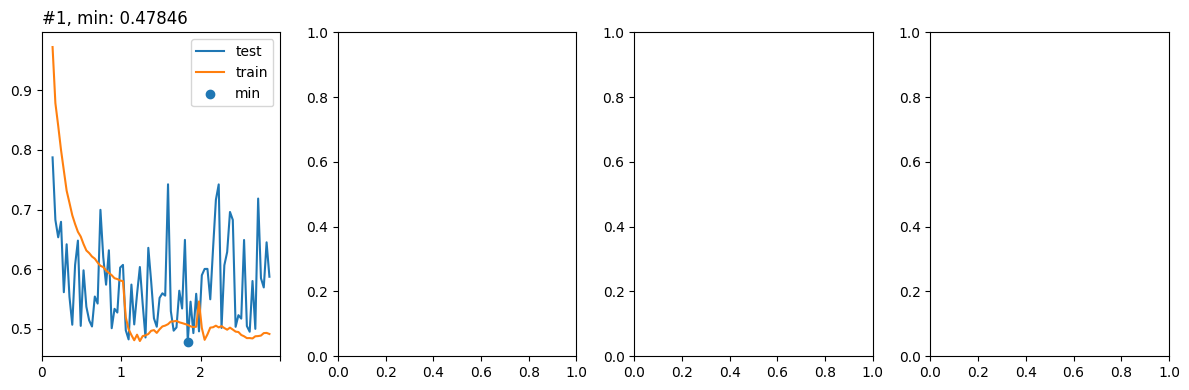

In [18]:
# def cross_validation():
with open(prompts_train_path, encoding='utf-8') as f:
    prompts = pd.read_csv(f)
#     prompts = prompts[prompts.prompt_id != '3b9047'].reset_index(drop=True)

plt.figure(figsize=(12,4))

folds_list = list(prompts.prompt_id)
score_type = 'content'
batch_size = 10
lr = 2e-04
lr_head = 2e-04
weight_decay = 1e-02

n_epochs = 3

scores = []

fig, axs = plt.subplots(1, len(folds_list), figsize=(12,4), layout='tight')

for i, fold in enumerate(folds_list, 1):
    train_loader, test_loader = loaders_init(score_type, batch_size, fold, lr_head)

    best_score, n_iter, test_losses, train_losses = train_model(n_epochs, lr, weight_decay, i)

    scores.append(best_score)

    axs[i-1] = axis_set(axs[i-1])

mean_score = np.mean(scores)

fig.suptitle(f'CV={mean_score:.5f}')
fig.savefig('res_figure.png', dpi=200)

mean_score